In [1]:
import numpy as np
import sympy as sym
import scipy as sp
import matplotlib.pyplot as plt


In [2]:
t = sym.symbols('t')

def R(theta, phi, psi):
    # ZXZ
    M=[
        [sym.cos(theta)*sym.cos(psi)-sym.cos(phi)*sym.sin(theta)*sym.sin(psi), -sym.cos(theta)*sym.sin(psi)-sym.cos(phi)*sym.cos(psi)*sym.sin(theta), sym.sin(theta)*sym.sin(phi)],
        [sym.cos(psi)*sym.sin(theta)+sym.cos(theta)*sym.cos(phi)*sym.sin(psi), sym.cos(theta)*sym.cos(phi)*sym.cos(psi)-sym.sin(theta)*sym.sin(psi), -sym.cos(theta)*sym.sin(phi)],
        [sym.sin(phi)*sym.sin(psi), sym.cos(psi)*sym.sin(phi), sym.cos(phi)],
    ]
    return sym.Matrix(M)

def Rx(x):
    return sym.Matrix([
        [1,0,0],
        [0,sym.cos(x),-sym.sin(x)],
        [0,sym.sin(x),sym.cos(x)],
    ])

def V(k, R1,R2):
    # return k*sym.trace((R1.T*R2)* R1.T * R2 *(R1.T*R2))
    return k*sym.trace((R1.T*R2)*(R1.T*R2))

def K(k, R1):
    return k*sym.trace((R1.T * R1.diff(t))*(R1.T * R1.diff(t)))

def Anis(k, R1, eq, dphi):
    # Re = Rx(dphi)*R(eq[0],eq[1],eq[2])*Rx(-dphi)
    Re = R(0,dphi,0)*R(eq[0],eq[1],eq[2])*R(0,-dphi,0)
    return k*sym.trace((R1.T * Re)*(R1.T * Re))

def coefficients(expresions, variables):
    """returns a [N,N] python list"""
    eqs = []
    vars = []
    for i in expresions:
        for j in i:
            eqs.append(j)

    for i in variables:
        for j in i:
            vars.append(j)

    N = len(vars)
    out = []
    for i in range(N):
        l = []
        for j in range(N):
            l.append((eqs[i].lhs).coeff(vars[j]))
        out.append(l)
    return sym.Matrix(out)

In [3]:
class System:
    def __init__(self, Nbase, indexConnections, dirconnections, a=1,k_v=1, k_k=1, k_a=1, dphi=0, Js=1):
        self.Nbase = Nbase
        self.indexConnections=indexConnections
        self.directionConnections = dirconnections
        self.a=a
        self.k = [sym.symbols("k_x"), sym.symbols("k_y")]
        self.k_v = k_v
        self.k_k = k_k
        self.k_a = k_a
        self.dphi=dphi

        t = sym.symbols('t')
        self.auxvar=[
                sym.Function(r"\theta_a")(t),
                sym.Function(r"\phi_a")(t),
                sym.Function(r"\psi_a")(t),
        ]
        self.auxvar2 = [
            sym.Function(r"\theta_b")(t),
            sym.Function(r"\phi_b")(t),
            sym.Function(r"\psi_b")(t),
        ]
        self.auxeq = [
            sym.symbols(r"\alpha"),
            sym.symbols(r"\beta"),
            sym.symbols(r"\gamma"),
        ]
        self.auxeq2 = [
            sym.symbols(r"\alpha_2"),
            sym.symbols(r"\beta_2"),
            sym.symbols(r"\gamma_2"),
        ]

        self.eigenvecs=None
        self.eigenvals=None

        if type(Js)==int: self.Js = 0 * self.indexConnections + self.k_v # todos tienen el mismo J 
        else:
            self.Js = Js  # debe ser un arreglo con el J de cada conexion


    def setEquilibrium(self, eq):
        t = sym.symbols('t')

        self.equilibrium = eq
        self.variables = []
        for i in range(self.Nbase):
            aux = [
                sym.Function(r"\theta_{}".format(i))(t),
                sym.Function(r"\phi_{}".format(i))(t),
                sym.Function(r"\psi_{}".format(i))(t),
            ]
            self.variables.append(aux)

        self.Rs = []
        for i in range(self.Nbase):
            R1 = R(
                self.equilibrium[i][0]+self.variables[i][0],
                self.equilibrium[i][1]+self.variables[i][1],
                self.equilibrium[i][2]+self.variables[i][2],
            )
            self.Rs.append(R1)

    def makeLagrangian(self):
        t = sym.symbols('t')

        Ls=[]

        for i in range(self.Nbase):
            kinetic = self.Kinetic(self.variables[i], self.equilibrium[i])
            potential = 0
            potential += self.Anisotropy(self.variables[i], self.equilibrium[i], i)
            for j in range(len(self.indexConnections[i])):
                idxconn = self.indexConnections[i][j]
                dirconn = self.directionConnections[i][j]
                k = 0
                for m in range(2):
                    k += dirconn[m]*self.k[m]
                factor = sym.exp(sym.I * self.a * k)
                if i==idxconn:
                    var = []
                    for z in self.auxvar:
                        var.append(z*factor)
                    potential += self.Potential(self.variables[i],self.equilibrium[i], var, self.equilibrium[idxconn], self.Js[i][j])
                else:
                    var=[]
                    for z in self.variables[idxconn]:
                        var.append(z*factor)
                    potential += self.Potential(self.variables[i], self.equilibrium[i], var,self.equilibrium[idxconn], self.Js[i][j])
            L = kinetic+potential
            Ls.append(L)

        self.lagrangians=Ls

    def equations(self):
        t = sym.symbols('t')

        self.E_L_equations=[]
        for i in range(self.Nbase):
            eq = sym.euler_equations(self.lagrangians[i], self.variables[i],t)
            self.E_L_equations.append(eq)

        # Replace varsaux por la variable correspondiente por el factor
        # esto solo es necesario si tenemos conexion a-a o b-b, etc
        
    def Kmatrix(self):
        t = sym.symbols('t')
        ddvar = []
        for i in self.variables:
            l = []
            for j in i:
                l.append(j.diff(t,2))
            ddvar.append(l)

        self.K = coefficients(self.E_L_equations, self.variables)
        self.W = -1*coefficients(self.E_L_equations, ddvar) # el -1 es por dt^2 -> -w^2

    def Wmatrix(self):
        newvar = []
        for i in range(self.Nbase):
            newvar.append(
                [
                    sym.symbols("a_{}".format(i)),
                    sym.symbols("b_{}".format(i)),
                    sym.symbols("c_{}".format(i)),
                ]
            )

        eqs = []
        for leq in self.E_L_equations:
            l = []
            for eq in leq:
                x = eq
                for i in range(self.Nbase):
                    for j in range(3):
                        ddvar = self.variables[i][j].diff(t, 2)
                        x = x.subs(ddvar, newvar[i][j])
                l.append(x)
            eqs.append(l)

        self.W = -1*coefficients(eqs, newvar)

    def seriesExpansion(self):
        epsilon = sym.symbols(r"\epsilon")
        littleauxvar1 = [
            self.auxeq[0] + epsilon*self.auxvar[0],
            self.auxeq[1] + epsilon*self.auxvar[1],
            self.auxeq[2] + epsilon*self.auxvar[2],
        ]
        littleauxvar2 = [
            self.auxeq2[0] + epsilon*self.auxvar2[0],
            self.auxeq2[1] + epsilon*self.auxvar2[1],
            self.auxeq2[2] + epsilon*self.auxvar2[2],
        ]
        R1 = R(littleauxvar1[0], littleauxvar1[1], littleauxvar1[2])
        R2 = R(littleauxvar2[0], littleauxvar2[1], littleauxvar2[2])

        # self.V = sym.series(V(self.k_v, R1, R2),epsilon, 0, 3).removeO().subs(epsilon,1)
        # self.K = sym.series(K(self.k_k, R1),epsilon, 0, 3).removeO().subs(epsilon,1)
        self.V = V(self.k_v, R1, R2).diff(epsilon, 2).subs(epsilon,0)
        self.K = K(self.k_k, R1).diff(epsilon, 2).subs(epsilon,0)
        self.A = Anis(self.k_a, R1, self.auxeq, self.auxeq2[0]).diff(epsilon, 2).subs(epsilon,0)
        
    def Potential(self, angles1,eq1, angles2, eq2, k):
        return self.V.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            (self.auxvar2[0], angles2[0]),(self.auxvar2[1], angles2[1]),(self.auxvar2[2], angles2[2]),
            (self.auxeq2[0], eq2[0]),(self.auxeq2[1], eq2[1]),(self.auxeq2[2], eq2[2]),
            (self.k_v, k)
            ])

    def Kinetic(self, angles1, eq1):
        return self.K.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            ])
    
    def Anisotropy(self, angles1, eq1, idx):
        return self.A.subs([
            (self.auxvar[0], angles1[0]),(self.auxvar[1], angles1[1]),(self.auxvar[2], angles1[2]),
            (self.auxeq[0], eq1[0]),(self.auxeq[1], eq1[1]),(self.auxeq[2], eq1[2]),
            (self.auxeq2[0], ((-1)**idx)*self.dphi),
        ])

    def eigen(self, N=50):
        ks = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        self.eigenvals = np.zeros([N, self.Nbase*3])
        self.eigenvecs = np.zeros([N, self.Nbase*3, self.Nbase*3], dtype=complex)

        for i in range(N):
            A = np.array(self.K.subs(self.k[0], ks[i])).astype(dtype=complex)
            B = np.array(self.W.subs(self.k[0], ks[i])).astype(dtype=complex)
            eig = sp.linalg.eig(A,B)
            idx = np.argsort(eig[0].real)
            for j in range(self.Nbase*3):    
                self.eigenvals[i][j] = eig[0][idx[j]]
                # self.eigenvecs[i][j] = eig[1][idx[j]]
                vec = eig[1][idx[j]]
                if vec[0] != 0:
                    vec /= vec[0]
                vec /= np.linalg.norm(vec)
                self.eigenvecs[i][j] = vec # se elige el gauge tq el primer elemento es 1 (real)

    def eigen2D(self, N=50, print=0):
        kx = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        ky = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        X, Y = np.meshgrid(kx, ky)
        
        self.BZ = np.array([kx, ky])

        self.eigenvals = np.zeros([N,N,self.Nbase*3])
        self.eigenvecs = np.zeros([N,N,self.Nbase*3, self.Nbase*3], dtype=complex)

        for i in range(N):
            for j in range(N):
                A = np.array(self.K.subs([(self.k[0], X[i,j]), (self.k[1], Y[i,j])])).astype(dtype=complex)
                B = np.array(self.W.subs([(self.k[0], X[i,j]), (self.k[1], Y[i,j])])).astype(dtype=complex)
                eig = sp.linalg.eig(A,B)
                idx = np.argsort(eig[0].real)
                if print==1: print(eig[0])
                for k in range(self.Nbase*3):
                    self.eigenvals[i][j][k] = eig[0][idx[k]]
                    # self.eigenvecs[i][j][k] = eig[1][idx[k]]
                    vec = eig[1][idx[k]] / eig[1][idx[k]][0]
                    vec /= np.linalg.norm(vec)
                    self.eigenvecs[i][j][k] = vec

        fig = plt.figure()
        fig.clf()
        ax = plt.axes(projection='3d')
        # ax.plot_surface(X,Y, self.eigenvals[:,:,0])
        # ax.plot_surface(X,Y, self.eigenvals[:,:,1])
        ax.contour3D(X,Y,self.eigenvals[:,:,0],50, cmap='binary')
        ax.contour3D(X,Y,self.eigenvals[:,:,1],50,cmap='binary')



    def plotkx(self, N=50):
        ks = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        y = np.zeros([N, self.Nbase*3])
        
        plt.plot(ks, self.eigenvals)

        
    def plot2Dband(self, N=50):
        Gamma = np.array([0,0])
        X = np.array([np.pi/self.a, 0])
        M = np.array([np.pi/self.a, np.pi/self.a])

        pathGX = np.outer(np.linspace(0, 1, N), X-Gamma) + Gamma
        pathXM = np.outer(np.linspace(0, 1, N), M-X) + X
        pathMG = np.outer(np.linspace(0, 1, N), Gamma-M) + M
        path = np.concatenate([pathGX, pathXM, pathMG])

        y = np.zeros([3*N, self.Nbase*3])

        for i in range(3*N):
            A = np.array(self.K.subs([(self.k[0], path[i][0]),(self.k[1], path[i][1])])).astype(dtype=complex)
            B = np.array(self.W.subs([(self.k[0], path[i][0]),(self.k[1], path[i][1])])).astype(dtype=complex)
            eig = sp.linalg.eig(A, B)[0]
            y[i] = np.sort(eig)
     
        
        k1 = np.linspace(0,1,N)
        k2 = np.linspace(1,2,N)
        k3 = np.linspace(2,np.pi,N)
        ks = np.concatenate([k1,k2,k3])
        plt.plot(ks,y)
        plt.axvline(1, color='black')
        plt.axvline(2, color='black')


    def plot2D(self, N=50, band1=0, band2=1):
        kx = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        ky = np.linspace(-np.pi/self.a, np.pi/self.a, N)
        X, Y = np.meshgrid(kx, ky)
        
        fig = plt.figure()
        fig.clf()
        ax = plt.axes(projection='3d')
        ax.plot_surface(X,Y,self.eigenvals[:,:,band1])
        ax.plot_surface(X,Y,self.eigenvals[:,:,band2])
        # ax.contour3D(X,Y,Z1,50, cmap='binary')
        # ax.contour3D(X,Y,Z2,50,cmap='binary')

    def initialize(self, equilibrium):
        self.setEquilibrium(equilibrium)
        self.seriesExpansion()
        self.makeLagrangian()
        self.equations()
        self.Kmatrix()
    
    def berryPhase(self,band=0):
        N = len(self.eigenvals[:,0])
        bp=0
        for i in range(N):
            # bpi = np.imag(np.dot(np.conj(self.eigenvecs[i][band])/np.linalg.norm(self.eigenvecs[i][band]),
                        #   self.eigenvecs[(i+1)%N][band]/np.linalg.norm(self.eigenvecs[(i+1)%N][band])-self.eigenvecs[i][0]/np.linalg.norm(self.eigenvecs[i][band]))
            # )
            bpi = np.imag(
                np.log(np.dot(
                    np.conj(self.eigenvecs[i][band]),
                    self.eigenvecs[(i+1)%N][band]
                            ) / np.linalg.norm(np.dot(
                    np.conj(self.eigenvecs[i][band]),
                    self.eigenvecs[(i+1)%N][band]
                            ))
                    )
            )
            print(bpi)
            bp += bpi
            # bpi = np.imag(
            #     np.log(np.dot(
            #         np.conj(self.eigenvecs[i][band])/np.linalg.norm(self.eigenvecs[i][band]),
            #         self.eigenvecs[(i+1)%N][band]/np.linalg.norm(self.eigenvecs[(i+1)%N][band])
            #                 )
            #         )
            # )
        self.bp=np.mod(bp, 2*np.pi)
        return self.bp
    
    def computeChern(self):
        BZ = self.BZ

        N = len(BZ[0])

        F = np.zeros([N,N,self.Nbase*3])
        U1 = np.zeros([N,N,self.Nbase*3], dtype=complex)
        U2 = np.zeros([N,N,self.Nbase*3], dtype=complex)

        for i in range(N):
            for j in range(N):
                for band in range(self.Nbase*3):
                    U1[i][j][band] = np.dot(
                        np.conj(self.eigenvecs[i][j][band]), self.eigenvecs[(i+1)%N][j][band]
                    )
                    U1[i][j][band] /= np.linalg.norm(U1[i][j][band])
                    U2[i][j][band] = np.dot(
                        np.conj(self.eigenvecs[i][j][band]), self.eigenvecs[i][(j+1)%N][band]
                    )
                    U2[i][j][band] /= np.linalg.norm(U2[i][j][band])
                    
        for i in range(N):
            for j in range(N):
                for band in range(self.Nbase*3):
                    F[i][j][band] = np.imag(np.log(
                        U1[i][j][band] * U2[(i+1)%N][j][band] * (U1[i][(j+1)%N][band])**(-1) * (U2[i][j][band])**(-1)
                    ))
                    F[i][j][band] = np.mod(F[i][j][band], 2*np.pi)

        self.chern = np.zeros(self.Nbase*3)
        for band in range(self.Nbase*3):
            self.chern[band] = np.mod(np.sum(F[:,:,band]), 2*np.pi) / (2*np.pi) 

        return self.chern
    
    
    def computeNonAbelianChern(self):
        BZ = self.BZ

        N = len(BZ[0])

        F = np.zeros([N,N])
        U1 = np.zeros([N,N], dtype=complex)
        U2 = np.zeros([N,N], dtype=complex)

        for i in range(N):
            for j in range(N):
                psiDag_psi1 = np.zeros([self.Nbase*3, self.Nbase*3])
                psiDag_psi2 = np.zeros([self.Nbase*3, self.Nbase*3])

                for band1 in range(self.Nbase*3):
                    for band2 in range(self.Nbase*3):

                        psiDag_psi1[band1][band2] = np.dot(
                            np.conj(self.eigenvecs[i][j][band1]), self.eigenvecs[(i+1)%N][j][band2]
                        ) 
                        psiDag_psi2[band1][band2] = np.dot(
                            np.conj(self.eigenvecs[i][j][band1]), self.eigenvecs[i][(j+1)%N][band2]
                        )
                det1 = np.linalg.det(psiDag_psi1)
                U1[i][j] = det1 / np.linalg.norm(det1)
                det2 = np.linalg.det(psiDag_psi2)
                U2[i][j] = det2 / np.linalg.norm(det2)

                    
        for i in range(N):
            for j in range(N):
                F[i][j] = np.imag(np.log(
                    U1[i][j] * U2[(i+1)%N][j] * (U1[i][(j+1)%N])**-1 * (U2[i][j])**-1
                ))
                F[i][j] = np.mod(F[i][j], 2*np.pi)

        self.chern = np.sum(F[:,:]) / (2*np.pi) 
        self.chern = np.mod(np.sum(F[:,:]), 2*np.pi) / (2*np.pi) 

        return self.chern

C:\Users\gdela\AppData\Local\Temp\ipykernel_30192\4135417161.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eigenvals[i][j] = eig[0][idx[j]]


-0.5918601945749659
0.029781401944200134
3.0893145874900645
0.041241019615919444
0.18754972926198424
0.021312464539798685
-0.142780079920297
0.03799144645005605
0.2861133043349697
0.7371943505865449
2.182134562510104
-0.9305881796781683
1.4682845268114553
2.59142629570698
-1.2652346752455557
-1.8060507164399602
3.074840713220706
-0.026554119133220963
-0.14245690758377372
0.824496410302995
-0.09075317203024101
0.0856058553578288
0.008292380893037023
0.3435825305077727
-0.04635091527597764
3.083534706417725
0.03410697578482228
0.02128346518335702
0.007453435294708933
-0.046146876267833675
-0.056853160510768046
-0.03254897363791762
1.160287017934921
-0.03352997308863318
-0.10342561800329617
2.6097802184908248
0.2977747679752978
-0.02330368805035699
0.15546240777988687
-0.04774428517520264
0.12283199407793466
0.10899373736627986
-3.095073804448693
0.21044011140584787
0.13016239784175315
-0.23062873730594788
-0.006943463596571555
3.0969637826692757
-0.36335002155192736
2.1058205285639797


0.2223236432629605

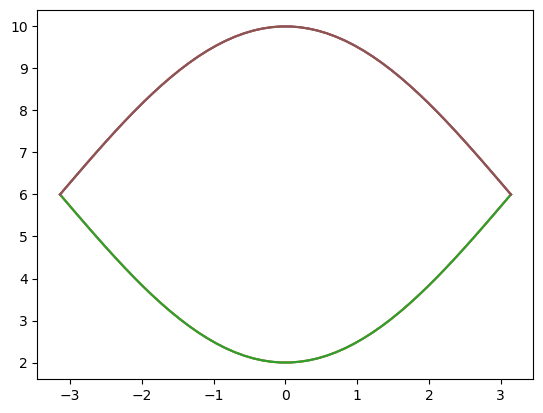

In [4]:
N=2
idxconn = np.array( [
    [1, 1],
    [0, 0],
])
# ahora la fila indica el rotor con el que se conecta, ie, la fila 0 dice que hay conexion [0,1], [0,1]

dirconn = [
    [[0,0], [-1,0]],
    [[0,0], [1,0]],
]

Js = np.array([
    [1,0.5],
    [1,0.5],
])

# chain = System(N, idxconn, dirconn, dphi=0.0, Js=Js)
chain = System(N, idxconn, dirconn, dphi=0.0)
chain.setEquilibrium([
    [np.pi/3,np.pi/3,np.pi/3], 
    [np.pi/3,np.pi/3,np.pi/3], 
    ])
# chain.setEquilibrium([
#     [0.1,0.8,0.5], 
#     [0.1,0.8,0.5], 
#     ])
chain.seriesExpansion()
chain.makeLagrangian()
chain.equations()
chain.Kmatrix()
chain.eigen()
chain.plotkx()
chain.berryPhase()
chain.bp

C:\Users\gdela\AppData\Local\Temp\ipykernel_30192\4135417161.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eigenvals[i][j] = eig[0][idx[j]]


1.7064621152871366
-0.17219242705177448
0.04130916705845849
3.094425059067389
-0.059410656202822834
-0.001687595706107721
-0.04485465626122412
-0.03832944953919616
-0.03505814461335308
-0.020548253522633418
-0.029685195154786542
-0.028525988398959715
-0.0171455902875855
-0.03242226362932417
-0.034941981145953725
-0.01152136105657624
-0.02533579314738074
-0.030338299474072662
-0.035276320580953736
-0.02148258667222133
-0.04299253562053267
-0.006237574068737047
-0.01364854172156675
-0.001050786981515198
-0.030404033641628
-0.00176806333246586
-0.01496950049751968
-0.00703334202384914
-0.04124452276394927
-0.030453286041545635
-0.03040395242529717
-0.034737635589859824
-0.025470654973158133
-0.01837070314733306
-0.034635217540111174
-0.03242226362932334
-0.017145590287589066
-0.028525988398951638
-0.017155602197324905
-0.030562508514709392
-0.03566267232899678
-0.020994838156408947
-0.040773633293325354
-0.00854898244690681
-0.044489502980104685
-3.00646441458928
0.019201318329538284
-0.0

6.046221455388782

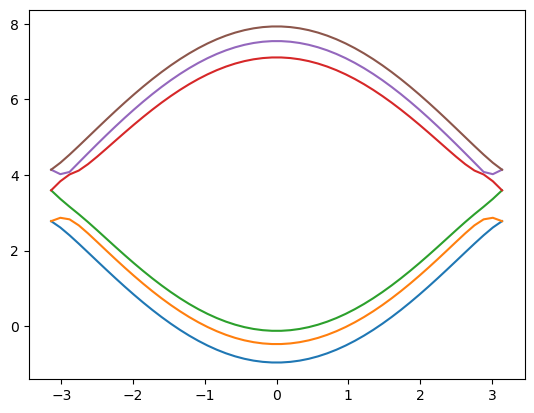

In [5]:
chain = System(N, idxconn, dirconn, dphi=1.5)
chain.setEquilibrium([
    [np.pi/3,np.pi/3,np.pi/3], 
    [np.pi/3,np.pi/3,np.pi/3], 
    ])
# chain.setEquilibrium([
#     [0.1,0.8,0.5], 
#     [0.1,0.8,0.5], 
#     ])
chain.seriesExpansion()
chain.makeLagrangian()
chain.equations()
chain.Kmatrix()
chain.eigen()
chain.plotkx()
chain.berryPhase()
chain.bp

In [6]:
chain.eigenvecs[1][2] - chain.eigenvecs[2][2]

array([-0.01942049+0.00000000e+00j, -0.79875417-1.93204575e-15j,
        0.02301178+2.35032449e-16j,  0.02908509-1.75600198e-02j,
        0.00209798+1.15059906e-01j, -1.0773269 +4.51318871e-02j])

In [7]:
np.linalg.norm(chain.eigenvecs[2][3])

1.0

In [8]:
chain.W

Matrix([
[                 -8.0, -4.44089209850063e-16,                 -4.0,                     0,                     0,                    0],
[-4.44089209850063e-16,                  -8.0, 1.11022302462516e-16,                     0,                     0,                    0],
[                 -4.0,  1.11022302462516e-16,                 -8.0,                     0,                     0,                    0],
[                    0,                     0,                    0,                  -8.0, -4.44089209850063e-16,                 -4.0],
[                    0,                     0,                    0, -4.44089209850063e-16,                  -8.0, 1.11022302462516e-16],
[                    0,                     0,                    0,                  -4.0,  1.11022302462516e-16,                 -8.0]])

In [9]:
idxconn = np.array([
    [1, 1,3,3],
    [0, 0,2,2],
    [1, 1,3,3],
    [0, 0,2,2],
])
dirconn = [
    [[0,0],[-1,0],[0,0],[0,1]],
    [[0,0],[1,0],[0,0],[0,1]],
    [[0,0],[0,-1],[0,0],[1,0]],
    [[0,0],[0,-1],[0,0],[-1,0]],
]
ladder = System(4, idxconn, dirconn)
ladder.initialize([
    [np.pi/3,np.pi/3,np.pi/3],
    [np.pi/3,np.pi/3,np.pi/3],
    [np.pi/3,np.pi/3,np.pi/3],
    [np.pi/3,np.pi/3,np.pi/3],
])
# ladder.initialize([
#     [0,0,0],
#     [0,0,0],
#     [0,0,0],
#     [0,0,0],
# ])

C:\Users\gdela\AppData\Local\Temp\ipykernel_30192\4135417161.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eigenvals[i][j][k] = eig[0][idx[k]]
C:\Users\gdela\AppData\Local\Temp\ipykernel_30192\4135417161.py:226: RuntimeWarning: divide by zero encountered in divide
  vec = eig[1][idx[k]] / eig[1][idx[k]][0]
C:\Users\gdela\AppData\Local\Temp\ipykernel_30192\4135417161.py:226: RuntimeWarning: invalid value encountered in divide
  vec = eig[1][idx[k]] / eig[1][idx[k]][0]
C:\Users\gdela\AppData\Local\Temp\ipykernel_30192\4135417161.py:227: RuntimeWarning: invalid value encountered in divide
  vec /= np.linalg.norm(vec)


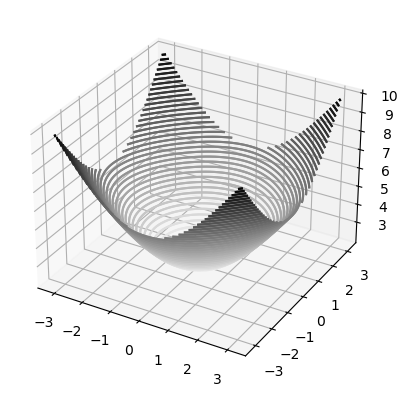

In [10]:
ladder.eigen2D()

In [11]:
# ladder.Wmatrix()
B = np.array(ladder.W, dtype=complex)
B
A = np.array(ladder.K.subs([(ladder.k[0], 0.5),(ladder.k[1],0.6)]), dtype=complex)
eig = sp.linalg.eig(A,B)

In [12]:
ladder.W

Matrix([
[                 -8.0, -4.44089209850063e-16,                 -4.0,                     0,                     0,                    0,                     0,                     0,                    0,                     0,                     0,                    0],
[-4.44089209850063e-16,                  -8.0, 1.11022302462516e-16,                     0,                     0,                    0,                     0,                     0,                    0,                     0,                     0,                    0],
[                 -4.0,  1.11022302462516e-16,                 -8.0,                     0,                     0,                    0,                     0,                     0,                    0,                     0,                     0,                    0],
[                    0,                     0,                    0,                  -8.0, -4.44089209850063e-16,                 -4.0,                     0,          

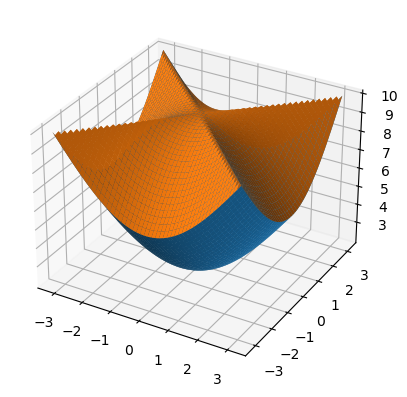

In [13]:
ladder.plot2D(band1=2,band2=3)

In [14]:
a = [
    [1,2,3],
    [1,2,3],
]

np.shape(a)

(2, 3)

In [15]:

eq = [
    [np.pi/3,np.pi/3, np.pi/3],
    [np.pi/3,np.pi/3, np.pi/3],
    ]
idxconn = np.array( [
    [1, 1],
    [0, 0],
])

dirconn = [
    [[0,0], [-1,0]],
    [[0,0], [1,0]],
]


def phasePlot(N, band=0):
    deltaJs = np.linspace(-1,1,N)
    dphis = np.linspace(-np.pi, np.pi, N)

    X, Y = np.meshgrid(dphis, deltaJs)
    Z = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            J = 1+Y[i][j]/2
            Jprime = 1-Y[i][j]/2
            Js = np.array([
                [J,Jprime],
                [J,Jprime],
            ])
            c = System(2, idxconn, dirconn, Js=Js, dphi=X[i][j])
            c.initialize(eq)
            # c.eigen(N=50)
            c.eigen(N=20) # para hacer mas fino el mesh
            out = c.berryPhase(band=band)
            print("i,j: [",i,',', j,"]")
            print("berry phase: ", out)
            Z[i,j] = out
    return X,Y,Z



C:\Users\gdela\AppData\Local\Temp\ipykernel_30192\4135417161.py:263: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i] = np.sort(eig)


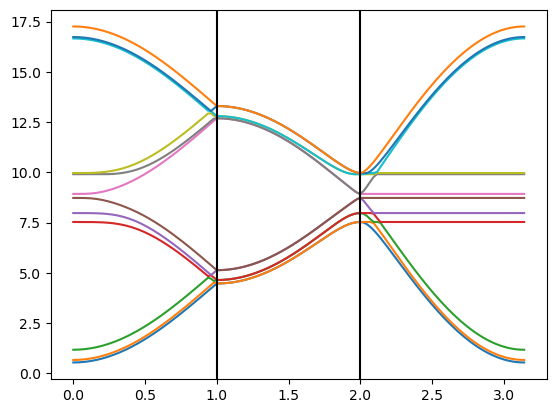

In [16]:
# idxconn = np.array([
#     [1, 1, 3, 2],
#     [0, 0, 2, 3],
#     [1, 0, 3, 3],
#     [0, 1, 2, 2],
# ])
# dirconn = [
#     [[0,0],[-1,0],[0,0],[0,1]],
#     [[0,0],[1,0],[0,0],[0,1]],
#     [[0,0],[0,-1],[0,0],[0,-1]],
#     [[0,0],[0,-1],[0,0],[0,1]],
# ]

idxconn = np.array([
    [1, 1, 3,3],
    [0, 0, 2,2],
    [1, 1, 3,3],
    [0, 0, 2,2],
])
dirconn = [
    [[0,0],[-1,0],[0,0],[0,1]],
    [[0,0],[1,0],[0,0],[0,1]],
    [[0,0],[0,-1],[0,0],[1,0]],
    [[0,0],[0,-1],[0,0],[-1,0]],
]

ladder = System(4, idxconn, dirconn, dphi=1.5)
ladder.initialize([
    [0.1, 0.8, 0.5],
    [0.1, 0.8, 0.5],
    [0.1, 0.8, 0.5],
    [0.1, 0.8, 0.5],
])

ladder.plot2Dband()

C:\Users\gdela\AppData\Local\Temp\ipykernel_30192\4135417161.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eigenvals[i][j][k] = eig[0][idx[k]]


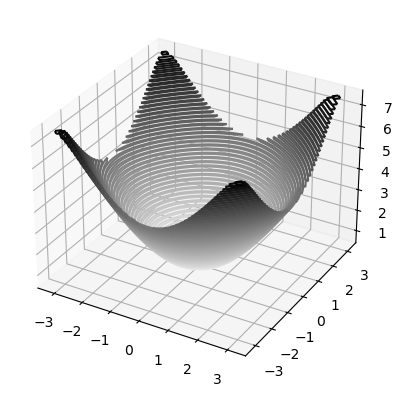

In [17]:
ladder.eigen2D()

In [18]:
chern = ladder.computeChern()
chern

array([4.18419638e-14, 2.82715972e-14, 1.07432069e-13, 1.00000000e+00,
       2.94024611e-14, 1.00000000e+00, 4.52345555e-15, 1.00000000e+00,
       1.00000000e+00, 4.52345555e-15, 1.00000000e+00, 5.42814666e-14])

In [19]:
ladder.computeNonAbelianChern()

C:\Users\gdela\AppData\Local\Temp\ipykernel_30192\4135417161.py:377: ComplexWarning: Casting complex values to real discards the imaginary part
  psiDag_psi1[band1][band2] = np.dot(
C:\Users\gdela\AppData\Local\Temp\ipykernel_30192\4135417161.py:380: ComplexWarning: Casting complex values to real discards the imaginary part
  psiDag_psi2[band1][band2] = np.dot(


431.0

In [24]:
print(
ladder.eigenvecs[1][2][4] - ladder.eigenvecs[2][2][4]
)

[-0.17436266+0.00000000e+00j  0.3977339 +3.33749940e-04j
  0.08720461-7.61114666e-16j -0.005387  -4.17805034e-02j
  0.01449425-3.29345899e-01j  0.4895156 -3.66020350e-02j
  0.17772   +6.16913062e-01j -0.08939995-1.88772413e-01j
  0.48000337-3.08172389e-02j -0.01350456+1.88450529e-01j
  0.17031083+1.24618818e-01j -0.03890684-1.64702895e-01j]


In [25]:
np.linalg.norm(ladder.eigenvecs[1][7][8])

0.9999999999999999

In [26]:
from matplotlib.colors import ListedColormap, TwoSlopeNorm
colors = plt.cm.viridis(np.linspace(0, 1, 256))
colors = np.vstack((colors, colors[0, :]))
# cyclic_cmap = ListedColormap(colors)

# cyclic_cmap = plt.get_cmap('twilight')
# cyclic_cmap = plt.get_cmap('twilight_shifted')]
cyclic_cmap = plt.get_cmap('hsv')

# Create a TwoSlopeNorm instance
norm = TwoSlopeNorm(vmin=0, vcenter=np.pi, vmax=2*np.pi)

X20, Y20, Z20 = phasePlot(20)

# plt.pcolormesh(X20, Y20, Z20, cmap=cyclic_cmap, norm=norm)
plt.imshow(Z20, cmap='hsv', norm=norm)
plt.colorbar()
plt.xlabel('$d\phi$')
plt.ylabel('$\Delta J$')

IndexError: list index out of range

In [ ]:
X2, Y2, Z2 = phasePlot(20, band=1)

# plt.pcolormesh(X20, Y20, Z20, cmap=cyclic_cmap, norm=norm)
plt.imshow(Z2, cmap='hsv', norm=norm)
plt.colorbar()
plt.xlabel('$d\phi$')
plt.ylabel('$\Delta J$')

C:\Users\gdela\AppData\Local\Temp\ipykernel_66692\2822993688.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eigenvals[i][j] = eig[0][idx[j]]


-1.3671762136499133
-0.143541436318299
-0.37502854686049564
-1.5766055766783262
-0.15352758533065364
-0.7493390828105099
0.6707135086313506
-0.21693610292204193
0.11859156768665699
0.3441240170202826
0.11859156768665699
-0.2169361029220395
0.6707135086313646
-0.7493390828105727
-0.15352758533071048
-1.5766055766783393
-0.37502854686049564
-0.143541436318299
-1.3671762136499133
1.7165128309258482
i,j: [ 0 , 0 ]
berry phase:  0.7581232186211366
-1.9412683375446091
-0.3554423578222056
0.6369986877106668
0.6039008266141073
-0.8547584269310601
0.4036265802624627
-0.08769638633136846
-0.041324646316883006
0.06629964265191418
0.7707120531362018
0.06629964265191418
-0.0413246463168829
-0.08769638633136606
0.4036265802624604
-0.8547584269311341
0.6039008266140986
0.6369986877106668
-0.3554423578222056
-1.9412683375446091
3.1049352277716893
i,j: [ 0 , 1 ]
berry phase:  0.7363184454938576
0.8714656804762074
0.14503977420935163
1.622598774840823
1.5883853812850381
-0.2132383393720575
-0.0824246577

KeyboardInterrupt: 